In [ ]:
#### Preamble ####
# Purpose: Model the data to predict BTC/USDT's moving direction
# Author: Jiazhou(Justin) Bi
# Date: 16 Nov 2024
# Contact: justin.bi@mail.utoronto.ca
# License: None
# Pre-requisites: see requirements.txt
# Any other information needed? None

# Loading the Test Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical, plot_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.utils import plot_model
df_1m = pd.read_parquet('../data/02-analysis_data/cleaned_data_1m.parquet')
df_1h = pd.read_parquet('../data/02-analysis_data/cleaned_data_1h.parquet')
df_1d = pd.read_parquet('../data/02-analysis_data/cleaned_data_1d.parquet')
df_1m.head()

,index,open,high,low,close,volume,was_missing,direction
0,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,0,0
1,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,0,1
2,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,0,-1
3,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,0,0
4,2017-08-17 04:05:00,4261.48,4261.48,4261.48,4261.48,0.000000,0,0


# RNN

## RNN for direction prediction

### 1-minute interval direction prediction

You must install pydot (`pip install pydot`) for `plot_model` to work.


c:\Users\melty\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 115s 1ms/step - accuracy: 0.0242 - loss: 0.9762 - val_accuracy: 0.0446 - val_loss: 0.9554
Epoch 2/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 113s 1ms/step - accuracy: 0.0243 - loss: 0.9759 - val_accuracy: 0.0446 - val_loss: 0.9554
Epoch 3/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 113s 1ms/step - accuracy: 0.0242 - loss: 0.9760 - val_accuracy: 0.0446 - val_loss: 0.9554
Epoch 4/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 114s 1ms/step - accuracy: 0.0244 - loss: 0.9760 - val_accuracy: 0.0446 - val_loss: 0.9558
Epoch 5/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 114s 1ms/step - accuracy: 0.0248 - loss: 0.9758 - val_accuracy: 0.0446 - val_loss: 0.9556
Epoch 6/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 114s 1ms/step - accuracy: 0.0250 - loss: 0.9758 - val_accuracy: 0.0446 - val_loss: 0.9554
Epoch 7/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 114s 1ms/step - accuracy: 0.0247 - loss: 0.9756 - val_accuracy: 0.0446 - val_loss: 0.9555
Epoch 8/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 115s 1ms/step - ac

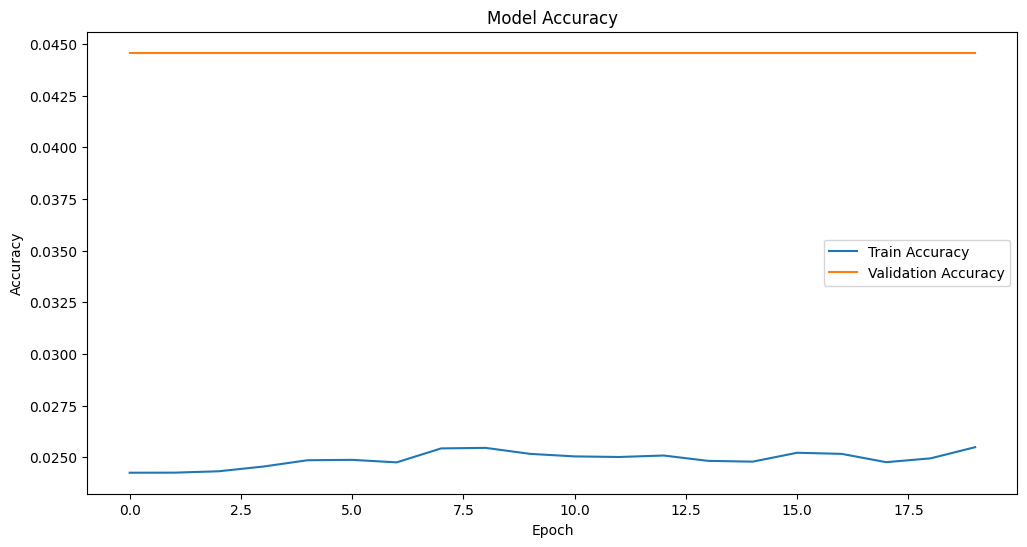

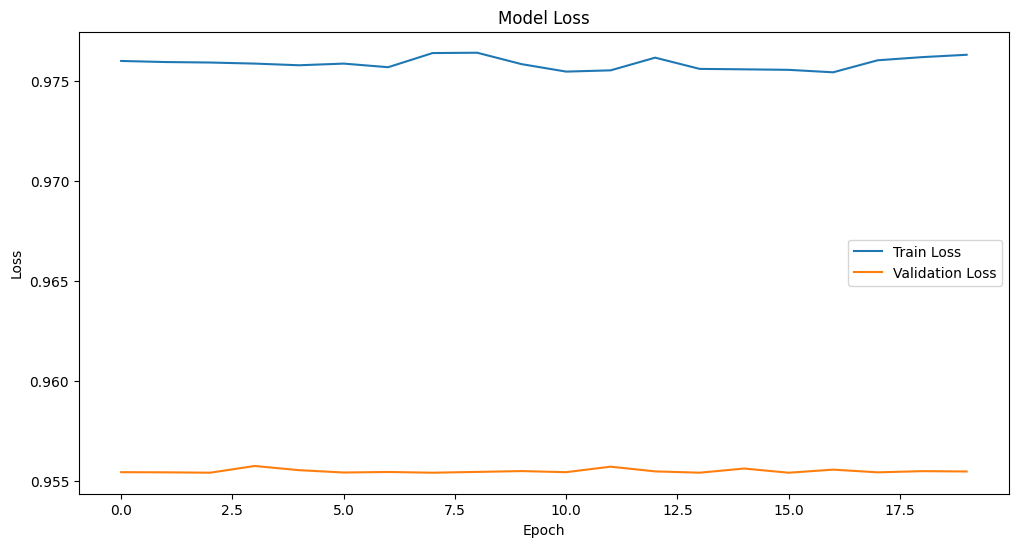

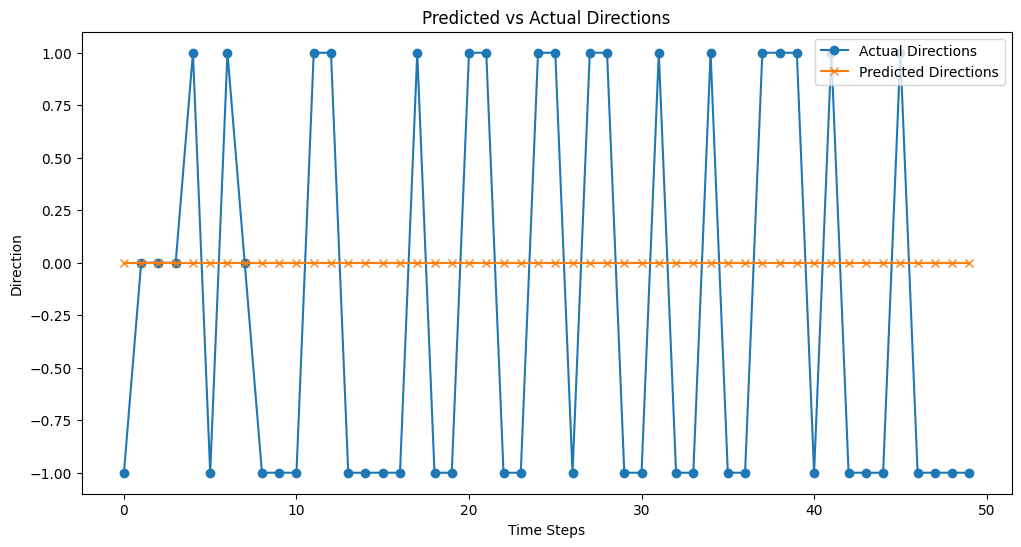

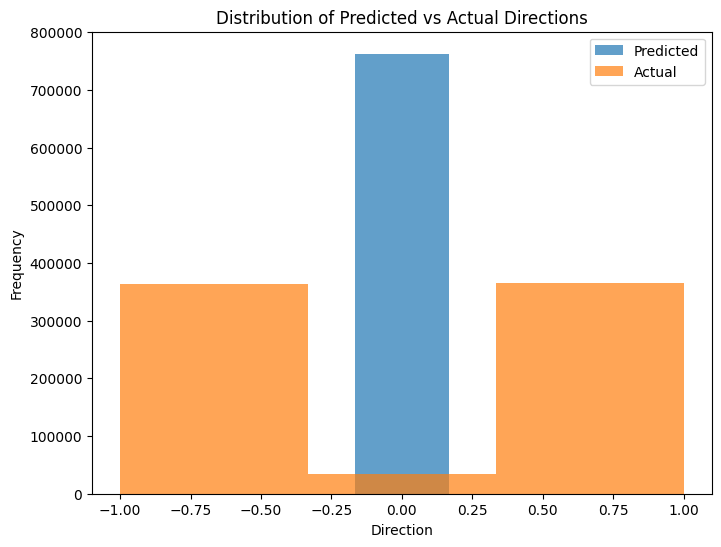

In [ ]:
# Define features and target
features = ['open', 'high', 'low', 'close', 'volume', 'was_missing']
target = 'direction'
X = df_1m[features]
y = df_1m[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Function to create sequences
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y.values, time_steps=time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Define the RNN model
model = Sequential([
    SimpleRNN(64, activation='relu', input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='tanh')  # Output for direction (-1, 0, 1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Visualize the model architecture
plot_model(model, to_file='rnn_model_architecture.png', show_shapes=True, show_layer_names=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict the directions
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred).flatten()  # Round to nearest class (-1, 0, 1)

# Visualize Training Progress
# Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize Predictions vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(y_test[:50], label='Actual Directions', marker='o')
plt.plot(y_pred_classes[:50], label='Predicted Directions', marker='x')
plt.title('Predicted vs Actual Directions')
plt.xlabel('Time Steps')
plt.ylabel('Direction')
plt.legend()
plt.show()

# Visualize Prediction Distribution
plt.figure(figsize=(8, 6))
plt.hist(y_pred_classes, bins=3, alpha=0.7, label='Predicted')
plt.hist(y_test, bins=3, alpha=0.7, label='Actual')
plt.title('Distribution of Predicted vs Actual Directions')
plt.xlabel('Direction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Save the model
model.save('rnn_direction_model_1m.h5')

### 1-hour interval direction prediction

### 1-day interval direction prediction

You must install pydot (`pip install pydot`) for `plot_model` to work.
Epoch 1/20


c:\Users\melty\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5231 - loss: 0.8675 - val_accuracy: 0.5208 - val_loss: 0.6969
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5073 - loss: 0.7162 - val_accuracy: 0.5227 - val_loss: 0.6935
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5192 - loss: 0.7052 - val_accuracy: 0.5208 - val_loss: 0.6944
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5153 - loss: 0.7019 - val_accuracy: 0.4792 - val_loss: 0.7069
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4983 - loss: 0.6969 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5150 - loss: 0.6962 - val_accuracy: 0.4830 - val_loss: 0.6943
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5094 - loss: 0.6947 - val_accuracy: 0.4678 - val_loss: 0.6945
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4924 - loss: 0.6981 - val_accuracy: 0.4848 - val_loss: 0.6963
Epo

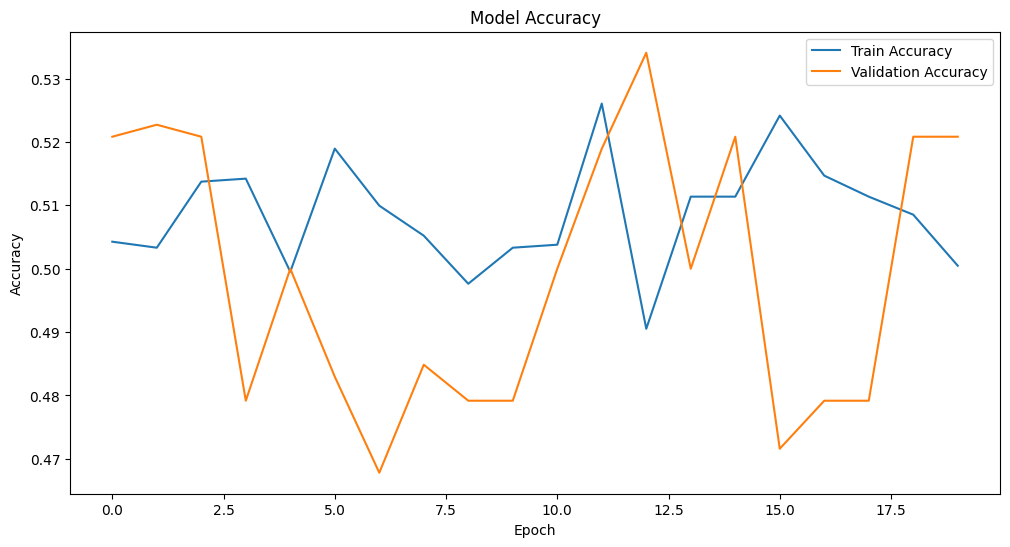

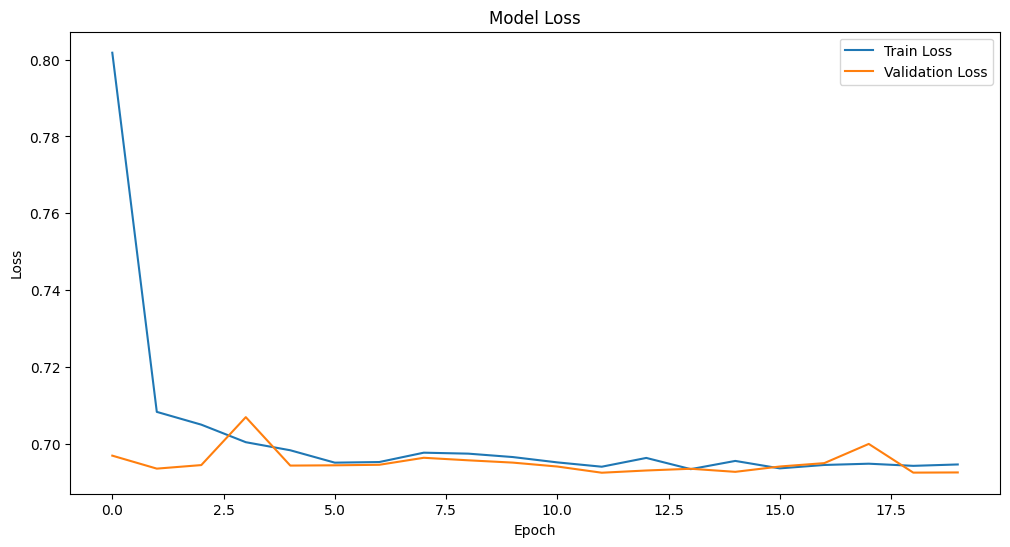

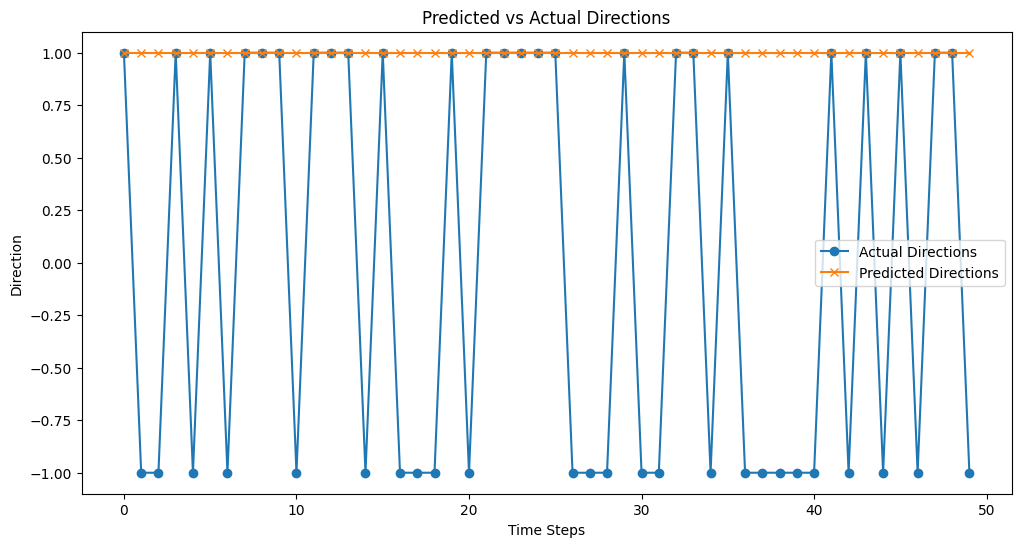

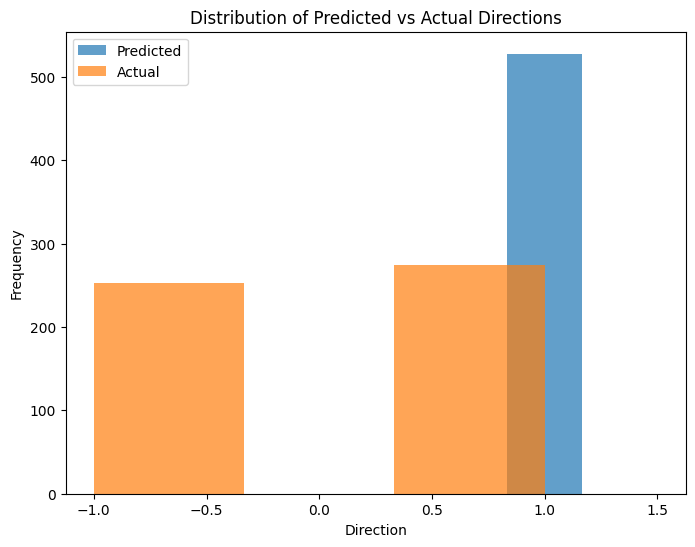

In [9]:
# Define features and target
features = ['open', 'high', 'low', 'close', 'volume']
target = 'direction'
X = df_1d[features]
y = df_1d[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert target to categorical
# Shift target values from (-1, 0, 1) to (0, 1, 2) for one-hot encoding
y_shifted = y + 1  # Shift values to be non-negative
y_categorical = to_categorical(y_shifted, num_classes=3)  # One-hot encode

# Function to create sequences
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y_categorical, time_steps=time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Define the RNN model
model = Sequential([
    SimpleRNN(64, activation='relu', input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # Output for 3 classes (-1, 0, 1 mapped to 0, 1, 2)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Visualize the model architecture
plot_model(model, to_file='rnn_model_architecture.png', show_shapes=True, show_layer_names=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict the directions
y_pred_prob = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1) - 1  # Convert back to (-1, 0, 1)

# Convert y_test back to original scale for comparison
y_test_classes = np.argmax(y_test, axis=1) - 1

# Visualize Training Progress
# Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize Predictions vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(y_test_classes[:50], label='Actual Directions', marker='o')
plt.plot(y_pred_classes[:50], label='Predicted Directions', marker='x')
plt.title('Predicted vs Actual Directions')
plt.xlabel('Time Steps')
plt.ylabel('Direction')
plt.legend()
plt.show()

# Visualize Prediction Distribution
plt.figure(figsize=(8, 6))
plt.hist(y_pred_classes, bins=3, alpha=0.7, label='Predicted')
plt.hist(y_test_classes, bins=3, alpha=0.7, label='Actual')
plt.title('Distribution of Predicted vs Actual Directions')
plt.xlabel('Direction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Save the model
model.save('../model/RNN/Directional_Classification_Model/rnn_direction_model_1d.h5')


# LSTM

# XGB